In [1]:
!nvidia-smi

Thu Nov 28 14:15:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-32GB           On  | 00000004:04:00.0 Off |                    0 |
| N/A   46C    P0              56W / 184W |   3482MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch
from torchvision import datasets, transforms

tensor_transform = transforms.Compose([
    transforms.ToTensor()
])

import os
try_data_dirs = ['/home/zhh/data','/home/zhh24/data']
for data_dir in try_data_dirs:
    if os.path.exists(data_dir):
        break
assert os.path.exists(data_dir), 'data_dir does not exist'

batch_size = 512
train_dataset = datasets.MNIST(root = data_dir,
									train = True,
									download = True,
									transform = tensor_transform)
test_dataset = datasets.MNIST(root = data_dir,
									train = False,
									download = True,
									transform = tensor_transform)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
							   batch_size = batch_size,
								 shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
							   batch_size = batch_size,
								 shuffle = False)

In [3]:
class Avger(list):
    def __str__(self):
        return f'{sum(self) / len(self):.4f}' if len(self) > 0 else 'N/A'
    
from tqdm.notebook import tqdm,trange
import torchvision.utils as vutils
import torch.nn as nn
import torch.nn.functional as F

In [4]:
from vanilla_unet import UNet as ModelCls

In [5]:
class BatchPrepareBase:
    def process(self, x):
        raise NotImplementedError

In [6]:
import os
import torchvision.utils as vutils
from tqdm import trange

class SamplerBase:
    def __init__(self):
        os.makedirs('samples', exist_ok=True)
        os.makedirs('checkpoints', exist_ok=True)
        
    def calc(self, model, num):
        raise NotADirectoryError()
    
    @torch.no_grad()
    def sample(self, model, num, desc):
        x = self.calc(model, num)
        grid = vutils.make_grid(x, nrow=8)
        vutils.save_image(grid, f'samples/{desc}.png')
        torch.save(model.state_dict(), f'checkpoints/{desc}.pth')
        

In [7]:
from IPython.display import Image, display


# Flow matching sanity

In [8]:
assert False

AssertionError: 

In [ ]:
class FM_BatchPrepare(BatchPrepareBase):
    def process(self, x):
        ts = torch.rand(x.shape[0], 1, 1, 1)
        noise = torch.randn_like(x)
        inputs = ts * x + (1 - ts) * noise
        targets = x - noise
        return inputs.cuda(), ts.reshape(-1).cuda(), targets.cuda()
        

In [ ]:
class FM_Sampler(SamplerBase):
    def __init__(self,T):
        super().__init__()
        self.T = T
    
    def calc(self,model,num):
        x = torch.randn(num, 1, 28, 28).cuda()
        dt = 1 / self.T
        for t in trange(self.T,desc='Sampling'):
            v = model(x,torch.tensor([t*dt]*num).cuda()*999)
            x = x + dt * v
        return x

In [ ]:
from tqdm import tqdm
class FM_Trainer:
    def __init__(self, model, epochs,lr,desc,preparer:BatchPrepareBase,sampler:SamplerBase, sample_ep=4):
        self.model = model
        self.epochs = epochs
        self.sample_ep = sample_ep
        self.lr = lr
        self.preparer = preparer
        self.sampler = sampler
        self.desc = desc
        
    def run(self):
        opt = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        for epoch in range(self.epochs):
            opt.param_groups[0]['lr'] = self.lr * (1-epoch/self.epochs)
            self.model.train()
            train_loss = Avger()
            with tqdm(train_loader) as bar:
                for x,_ in bar:
                    inputs, ts, targets = self.preparer.process(x)
                    pred = self.model(inputs, ts*999)
                    loss = F.mse_loss(pred, targets)
                    
                    opt.zero_grad()
                    loss.backward()
                    opt.step()
                    train_loss.append(loss.item())
                    bar.set_description(f'Epoch {epoch+1}/{self.epochs}, loss={train_loss}')
                    # break
                    
            if epoch == 0 or (epoch + 1) % self.sample_ep == 0 or epoch == self.epochs - 1:
                self.model.eval()
                self.sampler.sample(self.model, 64, f'ep{epoch+1}_{self.desc}')
                print(f'Epoch {epoch+1}, sample saved')

run

In [ ]:
model = ModelCls().cuda()
print('num of model parameters:', sum(p.numel() for p in model.parameters()))
trainer = FM_Trainer(model, 50, 1e-3, 'fm', FM_BatchPrepare(), FM_Sampler(100))
trainer.run()

num of model parameters: 2282673


Epoch 1/50, loss=1.9510:  14%|█▍        | 17/118 [00:03<00:20,  4.82it/s]


KeyboardInterrupt: 

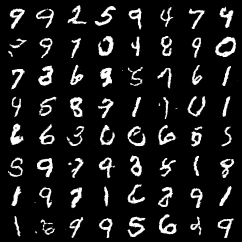

In [ ]:
from IPython.display import Image, display
display(Image('./samples/ep50_fm.png'))

# PixelCNN

In [19]:
from pixelcnn import PixelCNNContinous

In [27]:
from math import pi
class PixelCNN_C_BatchPrep(BatchPrepareBase):
    @staticmethod
    def gaussian_log_pdf(x, mu, logvar):
        var = torch.exp(logvar)
        return -0.5 * (torch.log(2 * torch.tensor(pi)) + logvar +((x - mu) ** 2) / var)
    
    def process(self, x):
        noisy = (x + torch.randn_like(x)) / 2
        return noisy.cuda()
    
class PixelCNN_C_Sampler(SamplerBase):
    def calc(self,model,num):
        # x = torch.randn(num, 1, 28, 28)
        x = torch.randn(num, 1, 28, 28).cuda()
        for i in trange(28):
            for j in range(28):
                mu, logvar = model(x)
                x[:, :, i, j] = torch.normal(mu[:, :, i, j], torch.exp(logvar[:, :, i, j]/2)).clamp(0, 1)
        return x
        

In [28]:
from tqdm import tqdm
class PixelCNN_Trainer:
    def __init__(self, model, epochs,lr,desc,preparer:PixelCNN_C_BatchPrep,sampler:SamplerBase, sample_ep=4):
        self.model = model
        self.epochs = epochs
        self.sample_ep = sample_ep
        self.lr = lr
        self.preparer = preparer
        self.sampler = sampler
        self.desc = desc
        
    def run(self):
        opt = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        for epoch in range(self.epochs):
            # opt.param_groups[0]['lr'] = self.lr * (1-epoch/self.epochs)
            self.model.train()
            train_loss = Avger()
            with tqdm(train_loader) as bar:
                for x,_ in bar:
                    inputs = self.preparer.process(x)
                    pred = self.model(inputs)
                    loss = -self.preparer.gaussian_log_pdf(inputs, pred[0], pred[1]).mean()
                    
                    opt.zero_grad()
                    loss.backward()
                    opt.step()
                    train_loss.append(loss.item())
                    bar.set_description(f'Epoch {epoch+1}/{self.epochs}, loss={train_loss}')
                    # break
                    
            if epoch == 0 or (epoch + 1) % self.sample_ep == 0 or epoch == self.epochs - 1:
                self.model.eval()
                self.sampler.sample(self.model, 64, f'ep{epoch+1}_{self.desc}')
                print(f'Epoch {epoch+1}, sample saved')

In [29]:
model = PixelCNNContinous().cuda()
print('num of model parameters:', sum(p.numel() for p in model.parameters()))
preparer = PixelCNN_C_BatchPrep()
# visualize a noisy batch
x = next(iter(train_loader))[0][:64]
noisy = preparer.process(x)
grid = vutils.make_grid(noisy, nrow=8)
vutils.save_image(grid, 'samples/noisy.png')

num of model parameters: 2490402


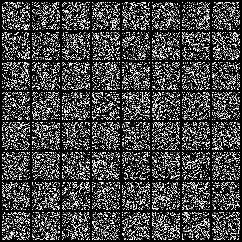

In [30]:
noise = torch.randn(64, 1, 28, 28)
grid = vutils.make_grid(noise, nrow=8)
vutils.save_image(grid, 'samples/noise.png')
from IPython.display import Image, display
display(Image('samples/noise.png'))

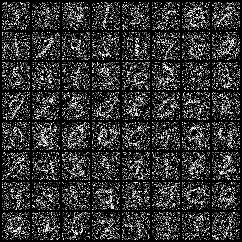

In [31]:
display(Image('samples/noisy.png'))

In [ ]:
trainer = PixelCNN_Trainer(model, 50, 1e-4, 'pixelcnn', preparer, PixelCNN_C_Sampler())
trainer.run()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:05<00:00,  4.96it/s]


Epoch 1, sample saved


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:05<00:00,  4.93it/s]


Epoch 4, sample saved


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:05<00:00,  4.93it/s]


Epoch 8, sample saved


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:05<00:00,  4.92it/s]


Epoch 12, sample saved


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:05<00:00,  4.93it/s]


Epoch 16, sample saved


Epoch 17/50, loss=0.7499:  29%|████████████████████████████████████████▎                                                                                                   | 34/118 [00:07<00:19,  4.38it/s]


KeyboardInterrupt: 

: 

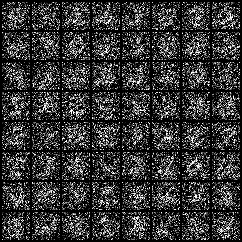

In [ ]:
display(Image('./samples/ep20_pixelcnn.png'))

# Train half flow matching

In [ ]:
class Half_FM_Sampler(SamplerBase):
    def __init__(self,T):
        super().__init__()
        self.T = T
    
    def calc(self,model,num):
        data = next(iter(test_loader))[0][:num].cuda()
        eps = torch.randn(num, 1, 28, 28).cuda()
        x = (data + eps) / 2
        dt = 1 / self.T
        for t in trange(self.T//2,self.T,desc='Sampling'):
            v = model(x,torch.tensor([t*dt]*num).cuda()*999)
            x = x + dt * v
        return x

In [ ]:
class Half_FM_BatchPrepare(BatchPrepareBase):
    def process(self,x):
        ts = (torch.rand(x.shape[0], 1, 1, 1) + 1)/2
        noise = torch.randn_like(x)
        inputs = ts * x + (1 - ts) * noise
        targets = x - noise
        return inputs.cuda(), ts.reshape(-1).cuda(), targets.cuda()

In [ ]:
model = ModelCls().cuda()
print('num of model parameters:', sum(p.numel() for p in model.parameters()))
trainer = FM_Trainer(model, 50, 1e-3, 'half_fm', Half_FM_BatchPrepare(), Half_FM_Sampler(100))
trainer.run()

num of model parameters: 2282673


Sampling: 100%|██████████| 50/50 [00:00<00:00, 187.33it/s]


Epoch 1, sample saved


Sampling: 100%|██████████| 50/50 [00:00<00:00, 187.88it/s]


Epoch 4, sample saved


Sampling: 100%|██████████| 50/50 [00:00<00:00, 186.84it/s]


Epoch 8, sample saved


Sampling: 100%|██████████| 50/50 [00:00<00:00, 187.54it/s]


Epoch 12, sample saved


Sampling: 100%|██████████| 50/50 [00:00<00:00, 186.66it/s]


Epoch 16, sample saved


Sampling: 100%|██████████| 50/50 [00:00<00:00, 182.19it/s]


Epoch 20, sample saved


Sampling: 100%|██████████| 50/50 [00:00<00:00, 188.14it/s]


Epoch 24, sample saved


Sampling: 100%|██████████| 50/50 [00:00<00:00, 187.60it/s]


Epoch 28, sample saved


Sampling: 100%|██████████| 50/50 [00:00<00:00, 186.46it/s]


Epoch 32, sample saved


Sampling: 100%|██████████| 50/50 [00:00<00:00, 187.13it/s]


Epoch 36, sample saved


Sampling: 100%|██████████| 50/50 [00:00<00:00, 185.51it/s]


Epoch 40, sample saved


Sampling: 100%|██████████| 50/50 [00:00<00:00, 184.85it/s]


Epoch 44, sample saved


Sampling: 100%|██████████| 50/50 [00:00<00:00, 186.24it/s]


Epoch 48, sample saved


Sampling: 100%|██████████| 50/50 [00:00<00:00, 186.52it/s]

Epoch 50, sample saved


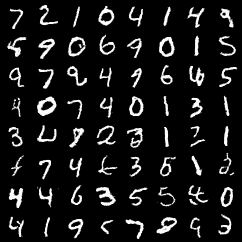

In [ ]:
display(Image('./samples/ep50_half_fm.png'))

sample

In [ ]:
class PixelCNN_Half_FM_Sampler(SamplerBase):
    def __init__(self,T,file):
        super().__init__()
        self.T = T
        self.pixelcnn = PixelCNNContinous().cuda()
        self.pixelcnn.load_state_dict(torch.load(file))
    
    def calc(self,model,num):
        # data = next(iter(test_loader))[0][:num].cuda()
        # eps = torch.randn(num, 1, 28, 28).cuda()
        # x = (data + eps) / 2
        x = torch.randn(num, 1, 28, 28).cuda()
        x = PixelCNN_C_Sampler().calc(self.pixelcnn,num)
        
        # save x 
        grid = vutils.make_grid(x, nrow=8)
        vutils.save_image(grid, 'samples/pixelcnn_test.png')
        
        
        dt = 1 / self.T
        for t in trange(self.T//2,self.T,desc='Sampling'):
            v = model(x,torch.tensor([t*dt]*num).cuda()*999)
            x = x + dt * v
        return x
    
PixelCNN_Half_FM_Sampler(1000,'./checkpoints/ep20_pixelcnn.pth').sample(model,64,desc='half_fm_pixelcnn')

/tmp/ipykernel_5430/2613291852.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.pixelcnn.load_state_dict(torch.load(file))
  0%|          | 0/28 [00:00<?, ?it/s]

Sampling: 100%|██████████| 500/500 [00:02<00:00, 180.24it/s]


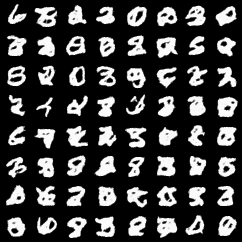

In [ ]:
display(Image('./samples/half_fm_pixelcnn.png'))

# Train half flow matching on pixelcnn

In [ ]:
assert False, 'stop!'
# generate data
pixelcnn = PixelCNNContinous().cuda()
pixelcnn.load_state_dict(torch.load('./checkpoints/ep20_pixelcnn_torch1.2.pth'))
pixelcnn = nn.DataParallel(pixelcnn)
# pixelcnn.load_state_dict(torch.load('./checkpoints/ep20_pixelcnn.pth'))
batch = 32768
total_num = 50000
xs = []
remains = total_num
for i in range(total_num//batch+1):
    print(f'{i+1}/{total_num//batch+1}')
    with torch.no_grad():
        x = PixelCNN_C_Sampler().calc(pixelcnn,min(batch,remains))
    remains -= x.shape[0]
    xs.append(x.cpu())
x = torch.cat(xs)[:total_num]
os.makedirs('./data',exist_ok=True)
torch.save(x,'./data/pixelcnn_data.pth')

1/2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [39:56<00:00, 85.61s/it]


2/2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [11:51<00:00, 25.43s/it]


In [ ]:
!du -h ./data/pixelcnn_data.pth

150M	./data/pixelcnn_data.pth


In [ ]:
file = './data/pixelcnn_data.pth'
d = torch.load(file)
print('d.shape:',d.shape)
grid = vutils.make_grid(d[:64],nrow=8)
vutils.save_image(grid,'samples/test_data.png')

d.shape: torch.Size([50000, 1, 28, 28])


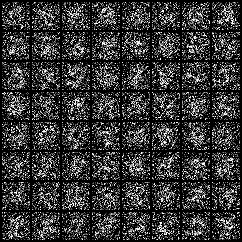

In [ ]:
display(Image('samples/test_data.png'))

load pixelcnn (sampling only)

In [ ]:
from pixelcnn import PixelCNNContinous
# generate data
pixelcnn = PixelCNNContinous().cuda()
pixelcnn.load_state_dict(torch.load('./checkpoints/ep20_pixelcnn_torch1.2.pth'))
pixelcnn = nn.DataParallel(pixelcnn)
# pixelcnn.load_state_dict(torch.load('./checkpoints/ep20_pixelcnn.pth'))
# batch = 32768
# total_num = 50000
# xs = []
# remains = total_num
# for i in range(total_num//batch+1):
#     print(f'{i+1}/{total_num//batch+1}')
#     with torch.no_grad():
#         x = PixelCNN_C_Sampler().calc(pixelcnn,min(batch,remains))
#     remains -= x.shape[0]
#     xs.append(x.cpu())
# x = torch.cat(xs)[:total_num]
# os.makedirs('./data',exist_ok=True)
# torch.save(x,'./data/pixelcnn_data.pth')

train flow matching

In [ ]:
class TruncDataset(torch.utils.data.Dataset):
    def __init__(self, data, num):
        self.data = data
        self.num = num
        
    def __getitem__(self, index):
        return self.data[index]
    
    def __len__(self):
        return self.num
trunc_train_set = TruncDataset(train_dataset, 50000)
print(len(trunc_train_set),len(d))
pixelcnn_loader = torch.utils.data.DataLoader(dataset = d, batch_size = 512, shuffle = True)
use_train_loader = torch.utils.data.DataLoader(dataset = trunc_train_set, batch_size = 512, shuffle = True)
len(use_train_loader),len(pixelcnn_loader)

50000 50000


(98, 98)

In [ ]:
class PixelCNN_FM_BatchPrepare(BatchPrepareBase):
    def process(self, x1, x2):
        # x2 is the data generated by pixelcnn
        ts = torch.rand(x1.shape[0], 1, 1, 1)
        inputs = ts * x1 + (1 - ts) * x2
        targets = x1 - x2
        # return inputs.cuda(), ts.reshape(-1).cuda(), targets.cuda()
        return inputs, ts.reshape(-1), targets

In [ ]:
class PixelCNN_FM_Sampler(SamplerBase):
    def __init__(self,T):
        super().__init__()
        self.T = T
    
    def calc(self,model,num):
        with torch.no_grad():
            x = PixelCNN_C_Sampler().calc(pixelcnn,num)
        x = x.cuda()
        dt = 1 / self.T
        for t in trange(self.T,desc='Sampling'):
            v = model(x,torch.tensor([t*dt]*num).cuda()*999)
            x = x + dt * v
        return x

In [ ]:
from tqdm import tqdm
class PixelCNN_FM_Trainer:
    def __init__(self, model, epochs,lr,desc,preparer:BatchPrepareBase,sampler:SamplerBase, sample_ep=4):
        self.model = model
        self.epochs = epochs
        self.sample_ep = sample_ep
        self.lr = lr
        self.preparer = preparer
        self.sampler = sampler
        self.desc = desc
        
    def run(self):
        opt = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        for epoch in range(self.epochs):
            opt.param_groups[0]['lr'] = self.lr * (1-epoch/self.epochs)
            self.model.train()
            train_loss = Avger()
            # print('train loader length:',len(train_loader))
            # print('pixelcnn loader length:',len(pixelcnn_loader))
            with tqdm(zip(use_train_loader,pixelcnn_loader),total=len(pixelcnn_loader)) as bar:
                # it = next(iter(bar))
                # print('it:',it)
                for (x,_),x_pixel in bar:
                    inputs, ts, targets = self.preparer.process(x,x_pixel)
                    pred = self.model(inputs, ts*999)
                    loss = F.mse_loss(pred, targets.cuda())
                    
                    opt.zero_grad()
                    loss.backward()
                    opt.step()
                    train_loss.append(loss.item())
                    bar.set_description(f'Epoch {epoch+1}/{self.epochs}, loss={train_loss}')
                    # break
                    
            if epoch == 0 or (epoch + 1) % self.sample_ep == 0 or epoch == self.epochs - 1:
                self.model.eval()
                self.sampler.sample(self.model, 64, f'ep{epoch+1}_{self.desc}')
                print(f'Epoch {epoch+1}, sample saved')

In [ ]:
model = ModelCls().cuda()
model = nn.DataParallel(model)
print('num of model parameters:', sum(p.numel() for p in model.parameters()))
trainer = PixelCNN_FM_Trainer(model, 50, 1e-3, 'pixelcnn_fm', PixelCNN_FM_BatchPrepare(), PixelCNN_FM_Sampler(100))
trainer.run()

num of model parameters: 2282673


Sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.77it/s]


Epoch 1, sample saved


Sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.83it/s]


Epoch 4, sample saved


Sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.79it/s]


Epoch 8, sample saved


Sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.78it/s]


Epoch 12, sample saved


Sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.77it/s]


Epoch 16, sample saved


Sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.80it/s]


Epoch 20, sample saved


Sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.77it/s]


Epoch 24, sample saved


Sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.76it/s]


Epoch 28, sample saved


Sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.79it/s]


Epoch 32, sample saved


Sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.76it/s]


Epoch 36, sample saved


Sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.77it/s]


Epoch 40, sample saved


Sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.74it/s]


Epoch 44, sample saved


Sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.77it/s]


Epoch 48, sample saved


Sampling: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.76it/s]


Epoch 50, sample saved


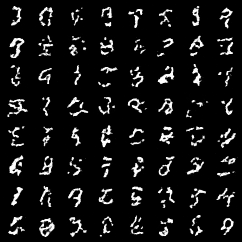

In [ ]:
display(Image('./samples/ep50_pixelcnn_fm.png'))

# TODO: this doesn't work yet